In [1]:
import pandas as pd
import plotly.express as px
import matplotlib.pyplot as plt 
import numpy as np
import seaborn as sns
from datetime import datetime,timedelta
from sklearn.preprocessing import LabelEncoder
import xgboost as xgb
from xgboost import plot_importance, plot_tree
from xgboost import XGBClassifier
import datetime
import holidays
from sklearn.preprocessing import LabelEncoder
import prophet
from sklearn.metrics import mean_squared_error
from xgboost import XGBRegressor, plot_importance
# from sktime.forecasting.model_selection import temporal_train_test_split
# from sktime.utils.plotting import plot_series

###

In [2]:
def pre_all(train, test):
    print(f"전처리 전 train 크기 : {train.shape}")
    print(f"전처리 전 test 크기 : {test.shape}")
    print("=================전처리 중=================")

    # 합쳐서 전처리하기
    train["timestamp"] = pd.to_datetime(train["timestamp"])
    test["timestamp"] = pd.to_datetime(test["timestamp"])
    df = pd.concat([train,test]).reset_index(drop = True)

    df.rename(columns={'supply(kg)':'supply', 'price(원/kg)':'price'},inplace=True)

    #년/월/일 추가
    df['year']=df['timestamp'].dt.year
    df['month']=df['timestamp'].dt.month
    df['day']=df['timestamp'].dt.day

    #요일 추가
    df['week_day']=df['timestamp'].dt.weekday

    # 년-월 변수 추가 : year-month의 형태
    le = LabelEncoder()
    df["year_month"] = df["timestamp"].map(lambda x :str(x.year) + "-"+str(x.month))

    # 라벨 인코딩
    df["year_month"] = le.fit_transform(df["year_month"])

    # 주차 변수 추가
    df["week"] = df["timestamp"].map(lambda x: datetime.datetime(x.year, x.month, x.day).isocalendar()[1])

    # 주차 누적값
    week_list=[]
    for i in range(len(df['year'])) :
        if df['year'][i] == 2019 :
            week_list.append(int(df['week'][i]))
        elif df['year'][i] == 2020 :
            week_list.append(int(df['week'][i])+52)
        elif df['year'][i] == 2021 :
            week_list.append(int(df['week'][i])+52+53)
        elif df['year'][i] == 2022 :
            week_list.append(int(df['week'][i])+52+53+53)
        elif df['year'][i] == 2023 :
            week_list.append(int(df['week'][i])+52+53+53+52)
    df['week_num']= week_list

    #수동으로 값 바꾸기
    df.loc[df['timestamp']=='2019-12-30','week_num']=52
    df.loc[df['timestamp']=='2019-12-31','week_num']=52


    # 계절 추가
    def make_season(x):
        if x in [12,1,2]:
            return 0
        elif x in [3,4,5]:
            return 1
        elif x in [6,7,8]:
            return 2
        elif x in [9,10,11]:
            return 3
        
    df["season"] =df["month"].map(lambda  x:make_season(x))

    # 공휴일 변수 추가
    def make_holi(x):
        kr_holi = holidays.KR()

        if x in kr_holi:
            return 1
        else:
            return 0
        
    df["holiday"] = df["timestamp"].map(lambda x : make_holi(x))
    
    # # 더미 변수 처리
    # df = pd.get_dummies(df, columns = ["corporation", "location"], drop_first=True)

    # train, test 분리하기
    train = df[~df["price"].isnull()].sort_values("timestamp").reset_index(drop = True)
    test = df[df["price"].isnull()].sort_values("timestamp").reset_index(drop=True)

    # # # train, test 분리하기
    # train = df[df["timestamp"]<"2023-03-04"]
    # test = df[df["timestamp"]>="2023-03-04"]

    print(f"전처리 후 train 크기 : {train.shape}")
    print(f"전처리 후 test 크기 : {test.shape}")

    return train, test

# 데이터 정보

In [3]:
# 데이터 불러오기
train = pd.read_csv("dataset/train.csv")
test = pd.read_csv("dataset/test.csv")
trade = pd.read_csv("dataset/international_trade.csv")
submission = pd.read_csv("dataset/sample_submission.csv")

# EDA

In [845]:
pivot_tg = train_pre[train_pre["item"]=="TG"].pivot(index = "timestamp", columns = ["item", "corporation", "location"], values= ["supply", "price"])

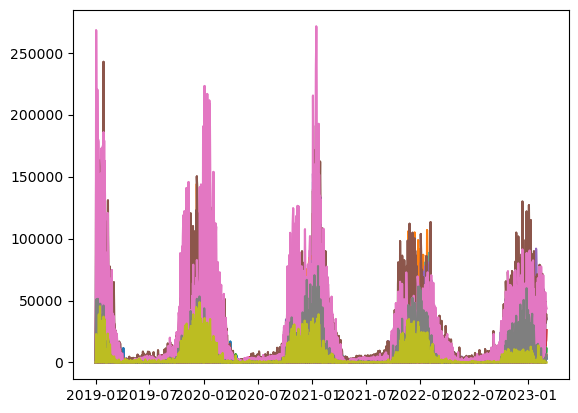

In [846]:
for idx in range(len(pivot_tg.columns)):
    if idx>0:
        item = pivot_tg.columns[idx][1]
        cor = pivot_tg.columns[idx][2]
        loc= pivot_tg.columns[idx][3]
        # coef = np.corrcoef(pivot_tg["supply"][item][cor][loc], pivot_tg["price"][item][cor][loc])[0][1]
        # print(f"item, corporation, location : {item, cor, loc} >> {coef}")
        plt.plot(pivot_tg["supply"][item][cor][loc])

In [892]:
best_shift = {}
for item in train_pre.item.unique():
    pivot_tg = pivot_tg = train_pre[train_pre["item"]==item].pivot(index = "timestamp", columns = ["item", "corporation", "location"], values= ["supply", "price"])
    max_coef = 0
    max_shift = 0
    shifts = list(range(366))
    for shift_ in shifts:
        coefs = []
        be_coefs =[]
        for idx in range(len(pivot_tg.columns)):
            if idx>0:
                item = pivot_tg.columns[idx][1]
                cor = pivot_tg.columns[idx][2]
                loc= pivot_tg.columns[idx][3]

                # print(item, cor, loc)
                be_sup = pivot_tg["supply"][item][cor][loc]
                be_prc = pivot_tg["price"][item][cor][loc]

                af_sup = pivot_tg["supply"][item][cor][loc].shift(shift_, fill_value =np.mean(pivot_tg["supply"][item][cor][loc]))
                af_prc = pivot_tg["price"][item][cor][loc]
                be_coef = np.corrcoef(be_sup,be_prc )[0][1]
                af_coef = np.corrcoef(af_sup,af_prc )[0][1]
                # print(f"item, corporation, location : {item, cor, loc} >> {coef}")
                # plt.plot(af_sup)
                # plt.plot(af_prc)
                # plt.show()
                # print(f"후상관계수 : {af_coef}")
                # print(f"전상관계수 : {be_coef}")
                # print(f"얼마나 나아졌는가: : {abs(af_coef) - abs(be_coef)}")
                coefs.append(af_coef)
                be_coefs.append(be_coef)
                coef_mean = np.mean(coefs)
                if coef_mean>max_coef:
                    max_shift =shift_
                    max_coef = coef_mean
    best_shift[item] = [max_shift, max_coef]
                # print()

In [903]:
best_shift

{'TG': [203, 0.545816559930777],
 'CB': [364, 0.6372051244221721],
 'RD': [0, 0.6382002448491304],
 'BC': [0, 0.5665953900592897],
 'CR': [0, 0.6812519281071853]}

### 감귤만 supply shift 해서 예측해보기(11/10)

In [46]:
train_pre, test_pre = pre_all(train, test)

전처리 전 train 크기 : (59397, 7)
전처리 전 test 크기 : (1092, 5)
=================전처리 중=================
전처리 후 train 크기 : (59397, 16)
전처리 후 test 크기 : (1092, 16)


In [41]:
# 새로 만들기
# nan값 같은 날의 평균으로 대체하기
df = pd.concat([train_pre, test_pre])
pivot_tg = df[df["item"]=="TG"].pivot(index = "timestamp", columns = ["item", "corporation", "location"], values= ["supply", "price"])
pivot_tg = pivot_tg.shift(203)["supply"]


pivot_tg_nan = pd.melt(pivot_tg.reset_index(), id_vars = "timestamp")

# 년/월/일 변수를 만든다.
pivot_tg_nan["timestamp"] = pd.to_datetime(pivot_tg_nan["timestamp"])
pivot_tg_nan["year"] = pivot_tg_nan["timestamp"].dt.year
pivot_tg_nan["month"] = pivot_tg_nan["timestamp"].dt.month
pivot_tg_nan["day"] = pivot_tg_nan["timestamp"].dt.day
pivot_tg_nan.head(5)

old = pd.DataFrame()
for cor in pivot_tg_nan.corporation.unique():
    for loc in pivot_tg_nan.location.unique():
        temp = pivot_tg_nan[(pivot_tg_nan["corporation"] == cor) & (pivot_tg_nan["location"]==loc)].pivot(index=["month", "day"], columns = ["year"], values= "value")
        temp = temp.transpose().fillna(temp.transpose().mean()).transpose()
        temp= pd.melt(temp.reset_index(), id_vars = ["month", "day"])
        temp["corporation"] =cor
        temp["location"] = loc
        new =pd.concat([old, temp])
        old = new

# 합치기
df = pd.merge(df, old, how = "left", on= ["year", "month", "day" ,"corporation","location"])

# 감귤 테이블 만들기
df_tg = df[df["item"]=="TG"]





# train, test 나누기
df_tg = pd.get_dummies(df_tg.sort_values(by =["corporation","location","timestamp"]).drop(columns = ["supply","season","ID","item"]), columns = ["corporation", "location"], drop_first=True).reset_index(drop=True)
df_tg["year"] = df_tg["year"].astype("int")

# # 일요일은 무조건 0값으로 변환
# for idx in range(len(df_tg)):
#     if df_tg.loc[idx, "week_day"]==6:
#         df_tg.loc[idx,"value"]=0
    
#     if df_tg.loc[idx,"holiday"]==1:
#         df_tg.loc[idx, "value"] = 0


train_tg = df_tg[~df_tg["price"].isnull()].reset_index(drop=True)
test_tg = df_tg[df_tg["price"].isnull()].reset_index(drop=True)

In [233]:
# nan 값 0으로 대체하기
df = pd.concat([train_pre, test_pre])
pivot_tg = df[df["item"]=="TG"].pivot(index = "timestamp", columns = ["item", "corporation", "location"], values= ["supply", "price"])
pivot_tg = pivot_tg.shift(203).fillna(0).reset_index()
pivot_tg = pd.melt(pivot_tg, id_vars = ["timestamp"])
pivot_tg = pivot_tg[pivot_tg[None]=="supply"]



# df와 합치기
df_tg = df[df["item"]=="TG"]
df_tg = pd.merge(df_tg, pivot_tg, how = "inner", on = ["timestamp","item", "corporation","location"])

# # 일요일은 무조건 0값으로 변환
# for idx in range(len(df_tg)):
#     if df_tg.loc[idx, "week_day"]==6:
#         df_tg.loc[idx,"value"]=0
    
#     if df_tg.loc[idx,"holiday"]==1:
#         df_tg.loc[idx, "value"] = 0


# train, test 나누기
df_tg = pd.get_dummies(df_tg.drop(columns = ["supply",None,"season","item"]), columns = ["corporation", "location"], drop_first=False)
train_tg = df_tg[~df_tg["price"].isnull()]
test_tg = df_tg[df_tg["price"].isnull()]

##### sorting전(리더 보드 점수 : 677)

In [4]:
# 일별 인덱스 추가해보기(train)
train_pre, test_pre = pre_all(train, test)
temp = pd.melt(pd.pivot(train_pre, columns = ["item","corporation","location"], index = "timestamp", values = "price").reset_index().reset_index(), id_vars = ["timestamp", "index"])
train_pre = pd.merge(train_pre, temp, how = "left", on = ["timestamp","item","corporation","location"]).drop(columns = ["supply","value","index","year_month"])

전처리 전 train 크기 : (59397, 7)
전처리 전 test 크기 : (1092, 5)
=================전처리 중=================
전처리 후 train 크기 : (59397, 16)
전처리 후 test 크기 : (1092, 16)


In [5]:
# 일별 인덱스 추가해보기(test)
temp = pd.melt(pd.pivot(test_pre, columns = ["item","corporation","location"], index = "timestamp", values = "price").reset_index().reset_index(), id_vars = ["timestamp", "index"])
test_pre = pd.merge(test_pre, temp, how = "left", on = ["timestamp","item","corporation","location"]).drop(columns = ["supply","price","value","index","year_month"])
test_pre.head(5)

,ID,timestamp,item,corporation,location,year,month,day,week_day,week,week_num,season,holiday
0,TG_A_J_20230304,2023-03-04,TG,A,J,2023,3,4,5,9,219,1,0
1,TG_E_S_20230304,2023-03-04,TG,E,S,2023,3,4,5,9,219,1,0
2,BC_B_J_20230304,2023-03-04,BC,B,J,2023,3,4,5,9,219,1,0
3,TG_E_J_20230304,2023-03-04,TG,E,J,2023,3,4,5,9,219,1,0
4,BC_B_S_20230304,2023-03-04,BC,B,S,2023,3,4,5,9,219,1,0


In [6]:
train_tg= pd.get_dummies(train_pre, columns = ["item","corporation","location"]).drop(columns = ["ID", "season"])
train_tg.head(5)

,timestamp,price,year,month,day,week_day,week,week_num,holiday,item_BC,...,item_RD,item_TG,corporation_A,corporation_B,corporation_C,corporation_D,corporation_E,corporation_F,location_J,location_S
0,2019-01-01,0.0,2019,1,1,1,1,1,1,0,...,0,1,1,0,0,0,0,0,1,0
1,2019-01-01,0.0,2019,1,1,1,1,1,1,0,...,0,0,1,0,0,0,0,0,0,1
2,2019-01-01,0.0,2019,1,1,1,1,1,1,0,...,1,0,0,0,0,1,0,0,1,0
3,2019-01-01,0.0,2019,1,1,1,1,1,1,1,...,0,0,0,0,0,1,0,0,1,0
4,2019-01-01,0.0,2019,1,1,1,1,1,1,0,...,0,0,0,0,0,0,0,1,1,0


In [7]:
train_tg.columns

Index(['timestamp', 'price', 'year', 'month', 'day', 'week_day', 'week',
       'week_num', 'holiday', 'item_BC', 'item_CB', 'item_CR', 'item_RD',
       'item_TG', 'corporation_A', 'corporation_B', 'corporation_C',
       'corporation_D', 'corporation_E', 'corporation_F', 'location_J',
       'location_S'],
      dtype='object')

In [8]:
cut_off = "2023-02-18"
x_train_sup= train_tg[train_tg["timestamp"]<cut_off].drop(columns = ["timestamp","price"])
x_valid_sup = train_tg[train_tg["timestamp"]>=cut_off].drop(columns = ["timestamp","price"])
y_train_sup, y_valid_sup = train_tg[train_tg["timestamp"]<cut_off]["price"] ,train_tg[train_tg["timestamp"]>=cut_off]["price"]
x_train_sup.head(5)

,year,month,day,week_day,week,week_num,holiday,item_BC,item_CB,item_CR,item_RD,item_TG,corporation_A,corporation_B,corporation_C,corporation_D,corporation_E,corporation_F,location_J,location_S
0,2019,1,1,1,1,1,1,0,0,0,0,1,1,0,0,0,0,0,1,0
1,2019,1,1,1,1,1,1,0,1,0,0,0,1,0,0,0,0,0,0,1
2,2019,1,1,1,1,1,1,0,0,0,1,0,0,0,0,1,0,0,1,0
3,2019,1,1,1,1,1,1,1,0,0,0,0,0,0,0,1,0,0,1,0
4,2019,1,1,1,1,1,1,0,1,0,0,0,0,0,0,0,0,1,1,0


In [9]:
### early stopping 
evals = [(x_valid_sup, y_valid_sup)]

xgb_wrapper = XGBRegressor(n_estimators = 1000, random_state = 2024, learning_rate = 0.01, max_depth = 10)
xgb_wrapper.fit(x_train_sup, y_train_sup, early_stopping_rounds =100, eval_set = evals, eval_metric = "rmse", verbose=True)
pred_sup = xgb_wrapper.predict(x_valid_sup)
for idx in range(len(pred_sup)):
    if pred_sup[idx]<0:
        pred_sup[idx]=0
print(np.sqrt(mean_squared_error(y_valid_sup, pred_sup)))

[0]	validation_0-rmse:2055.85738
[1]	validation_0-rmse:2036.86765
[2]	validation_0-rmse:2018.16589
[3]	validation_0-rmse:1999.60851
[4]	validation_0-rmse:1981.30947
[5]	validation_0-rmse:1963.20301


C:\Users\sybae\anaconda3\Lib\site-packages\xgboost\sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
C:\Users\sybae\anaconda3\Lib\site-packages\xgboost\sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[6]	validation_0-rmse:1945.32574
[7]	validation_0-rmse:1927.51621
[8]	validation_0-rmse:1910.05280
[9]	validation_0-rmse:1892.77081
[10]	validation_0-rmse:1875.74063
[11]	validation_0-rmse:1858.73649
[12]	validation_0-rmse:1842.10569
[13]	validation_0-rmse:1825.61830
[14]	validation_0-rmse:1809.35489
[15]	validation_0-rmse:1793.30038
[16]	validation_0-rmse:1777.46017
[17]	validation_0-rmse:1761.77723
[18]	validation_0-rmse:1746.30799
[19]	validation_0-rmse:1730.98507
[20]	validation_0-rmse:1715.92709
[21]	validation_0-rmse:1700.95986
[22]	validation_0-rmse:1686.25911
[23]	validation_0-rmse:1671.82364
[24]	validation_0-rmse:1657.43198
[25]	validation_0-rmse:1643.22319
[26]	validation_0-rmse:1629.14917
[27]	validation_0-rmse:1615.28359
[28]	validation_0-rmse:1601.59351
[29]	validation_0-rmse:1588.11552
[30]	validation_0-rmse:1574.96191
[31]	validation_0-rmse:1561.99854
[32]	validation_0-rmse:1549.02972
[33]	validation_0-rmse:1536.38171
[34]	validation_0-rmse:1523.88059
[35]	validation_0-

[248]	validation_0-rmse:724.69256
[249]	validation_0-rmse:724.53392
[250]	validation_0-rmse:724.17086
[251]	validation_0-rmse:723.69381
[252]	validation_0-rmse:723.49774
[253]	validation_0-rmse:723.43772
[254]	validation_0-rmse:723.10488
[255]	validation_0-rmse:722.81609
[256]	validation_0-rmse:722.50837
[257]	validation_0-rmse:722.17243
[258]	validation_0-rmse:721.89558
[259]	validation_0-rmse:721.42541
[260]	validation_0-rmse:721.23496
[261]	validation_0-rmse:720.59976
[262]	validation_0-rmse:720.06117
[263]	validation_0-rmse:719.70384
[264]	validation_0-rmse:719.37818
[265]	validation_0-rmse:718.81422
[266]	validation_0-rmse:718.24249
[267]	validation_0-rmse:718.38242
[268]	validation_0-rmse:717.97449
[269]	validation_0-rmse:717.30164
[270]	validation_0-rmse:717.57492
[271]	validation_0-rmse:717.30347
[272]	validation_0-rmse:717.07439
[273]	validation_0-rmse:717.22585
[274]	validation_0-rmse:717.25036
[275]	validation_0-rmse:717.36900
[276]	validation_0-rmse:717.56497
[277]	validati

In [10]:
### test 해보기
test_no_sort =  pd.get_dummies(test_pre, columns = ["item","corporation","location"]).drop(columns = ["ID", "season","timestamp"])
test_no_sort.head(5)

,year,month,day,week_day,week,week_num,holiday,item_BC,item_CB,item_CR,item_RD,item_TG,corporation_A,corporation_B,corporation_C,corporation_D,corporation_E,corporation_F,location_J,location_S
0,2023,3,4,5,9,219,0,0,0,0,0,1,1,0,0,0,0,0,1,0
1,2023,3,4,5,9,219,0,0,0,0,0,1,0,0,0,0,1,0,0,1
2,2023,3,4,5,9,219,0,1,0,0,0,0,0,1,0,0,0,0,1,0
3,2023,3,4,5,9,219,0,0,0,0,0,1,0,0,0,0,1,0,1,0
4,2023,3,4,5,9,219,0,1,0,0,0,0,0,1,0,0,0,0,0,1


In [11]:
print(f"test의 컬럼 : {test_no_sort.columns}")
print(f"train의 컬럼 : {x_valid_sup.columns}")
print(f"test의 컬럼 : {len(test_no_sort.columns)}")
print(f"train의 컬럼 : {len(x_valid_sup.columns)}")

test의 컬럼 : Index(['year', 'month', 'day', 'week_day', 'week', 'week_num', 'holiday',
       'item_BC', 'item_CB', 'item_CR', 'item_RD', 'item_TG', 'corporation_A',
       'corporation_B', 'corporation_C', 'corporation_D', 'corporation_E',
       'corporation_F', 'location_J', 'location_S'],
      dtype='object')
train의 컬럼 : Index(['year', 'month', 'day', 'week_day', 'week', 'week_num', 'holiday',
       'item_BC', 'item_CB', 'item_CR', 'item_RD', 'item_TG', 'corporation_A',
       'corporation_B', 'corporation_C', 'corporation_D', 'corporation_E',
       'corporation_F', 'location_J', 'location_S'],
      dtype='object')
test의 컬럼 : 20
train의 컬럼 : 20


In [12]:
train_tg.columns

Index(['timestamp', 'price', 'year', 'month', 'day', 'week_day', 'week',
       'week_num', 'holiday', 'item_BC', 'item_CB', 'item_CR', 'item_RD',
       'item_TG', 'corporation_A', 'corporation_B', 'corporation_C',
       'corporation_D', 'corporation_E', 'corporation_F', 'location_J',
       'location_S'],
      dtype='object')

In [13]:
### early stopping 
# evals = [(x_valid_sup, y_valid_sup)]

xgb_wrapper = XGBRegressor(n_estimators = 1000, random_state = 2024, learning_rate = 0.01, max_depth = 10)
xgb_wrapper.fit(train_tg.drop(columns = ["timestamp","price"]), train_tg["price"], eval_metric = "rmse", verbose=True)
pred_test_nosort = xgb_wrapper.predict(test_no_sort)
for idx in range(len(pred_test_nosort)):
    if pred_test_nosort[idx]<0:
        pred_test_nosort[idx]=0

C:\Users\sybae\anaconda3\Lib\site-packages\xgboost\sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(


In [14]:
train_tg.columns

Index(['timestamp', 'price', 'year', 'month', 'day', 'week_day', 'week',
       'week_num', 'holiday', 'item_BC', 'item_CB', 'item_CR', 'item_RD',
       'item_TG', 'corporation_A', 'corporation_B', 'corporation_C',
       'corporation_D', 'corporation_E', 'corporation_F', 'location_J',
       'location_S'],
      dtype='object')

In [15]:
test_no_sort.columns

Index(['year', 'month', 'day', 'week_day', 'week', 'week_num', 'holiday',
       'item_BC', 'item_CB', 'item_CR', 'item_RD', 'item_TG', 'corporation_A',
       'corporation_B', 'corporation_C', 'corporation_D', 'corporation_E',
       'corporation_F', 'location_J', 'location_S'],
      dtype='object')

In [16]:
answer_no_sort = pd.concat([test_pre["ID"],pd.DataFrame(pred_test_nosort, columns = ["answer"])], axis = 1)

In [17]:
answer_no_sort

,ID,answer
0,TG_A_J_20230304,2531.293457
1,TG_E_S_20230304,3649.999512
2,BC_B_J_20230304,2617.672852
3,TG_E_J_20230304,642.160950
4,BC_B_S_20230304,18.668722
...,...,...
1087,TG_A_J_20230331,6077.624512
1088,RD_D_J_20230331,299.896606
1089,CR_D_J_20230331,2135.696533
1090,TG_E_J_20230331,2328.794922


In [18]:
answer_no_sort.to_csv("dataset/answer1112_noindex_noyearmonth.csv" )

##### sorting 후

In [75]:
train_sort= pd.get_dummies(train_pre.sort_values(by = ["item","corporation","location","timestamp"]), columns = ["item","corporation","location"]).drop(columns = ["ID", "season"])
train_sort.head(5)

,timestamp,price,year,month,day,week_day,year_month,week,week_num,holiday,...,item_RD,item_TG,corporation_A,corporation_B,corporation_C,corporation_D,corporation_E,corporation_F,location_J,location_S
13,2019-01-01,0.0,2019,1,1,1,0,1,1,1,...,0,0,1,0,0,0,0,0,1,0
40,2019-01-02,0.0,2019,1,2,2,0,1,1,0,...,0,0,1,0,0,0,0,0,1,0
115,2019-01-03,2559.0,2019,1,3,3,0,1,1,0,...,0,0,1,0,0,0,0,0,1,0
143,2019-01-04,2425.0,2019,1,4,4,0,1,1,0,...,0,0,1,0,0,0,0,0,1,0
185,2019-01-05,2097.0,2019,1,5,5,0,1,1,0,...,0,0,1,0,0,0,0,0,1,0


In [76]:
train_sort.columnsz

Index(['timestamp', 'price', 'year', 'month', 'day', 'week_day', 'year_month',
       'week', 'week_num', 'holiday', 'index', 'item_BC', 'item_CB', 'item_CR',
       'item_RD', 'item_TG', 'corporation_A', 'corporation_B', 'corporation_C',
       'corporation_D', 'corporation_E', 'corporation_F', 'location_J',
       'location_S'],
      dtype='object')

In [147]:
cut_off = "2023-02-04"
x_train_sort= train_sort[train_sort["timestamp"]<cut_off].drop(columns = ["timestamp","price"])
x_valid_sort = train_sort[train_sort["timestamp"]>=cut_off].drop(columns = ["timestamp","price"])
y_train_sort, y_valid_sort = train_sort[train_sort["timestamp"]<cut_off]["price"] ,train_sort[train_sort["timestamp"]>=cut_off]["price"]
x_train_sort.tail(5)

,year,month,day,week_day,year_month,week,week_num,holiday,index,item_BC,...,item_RD,item_TG,corporation_A,corporation_B,corporation_C,corporation_D,corporation_E,corporation_F,location_J,location_S
58138,2023,1,30,0,48,5,215,0,1490,0,...,0,1,0,0,0,0,1,0,0,1
58178,2023,1,31,1,48,5,215,0,1491,0,...,0,1,0,0,0,0,1,0,0,1
58219,2023,2,1,2,49,5,215,0,1492,0,...,0,1,0,0,0,0,1,0,0,1
58252,2023,2,2,3,49,5,215,0,1493,0,...,0,1,0,0,0,0,1,0,0,1
58304,2023,2,3,4,49,5,215,0,1494,0,...,0,1,0,0,0,0,1,0,0,1


In [145]:
### early stopping 
evals = [(x_valid_sort, y_valid_sort)]

xgb_wrapper = XGBRegressor(n_estimators = 1000, random_state = 2024, learning_rate = 0.01, max_depth = 10)
xgb_wrapper.fit(x_train_sort, y_train_sort, early_stopping_rounds =100, eval_set = evals, eval_metric = "rmse", verbose=True)
pred_sort = xgb_wrapper.predict(x_valid_sort)
for idx in range(len(pred_sort)):
    if pred_sort[idx]<0:
        pred_sort[idx]=0
print(np.sqrt(mean_squared_error(y_valid_sort, pred_sort)))

[0]	validation_0-rmse:1854.57757
[1]	validation_0-rmse:1838.13080
[2]	validation_0-rmse:1821.82682
[3]	validation_0-rmse:1805.71741
[4]	validation_0-rmse:1789.85759
[5]	validation_0-rmse:1774.09641
[6]	validation_0-rmse:1758.60902


c:\Users\sybae\anaconda3\Lib\site-packages\xgboost\sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
c:\Users\sybae\anaconda3\Lib\site-packages\xgboost\sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[7]	validation_0-rmse:1743.27433
[8]	validation_0-rmse:1728.02254
[9]	validation_0-rmse:1713.03023
[10]	validation_0-rmse:1698.15866
[11]	validation_0-rmse:1683.51229
[12]	validation_0-rmse:1669.11176
[13]	validation_0-rmse:1654.82915
[14]	validation_0-rmse:1640.69991
[15]	validation_0-rmse:1626.87465
[16]	validation_0-rmse:1613.09707
[17]	validation_0-rmse:1599.52924
[18]	validation_0-rmse:1586.04892
[19]	validation_0-rmse:1572.82224
[20]	validation_0-rmse:1559.88615
[21]	validation_0-rmse:1546.97898
[22]	validation_0-rmse:1534.21169
[23]	validation_0-rmse:1521.48525
[24]	validation_0-rmse:1508.95721
[25]	validation_0-rmse:1496.74897
[26]	validation_0-rmse:1484.48748
[27]	validation_0-rmse:1472.70705
[28]	validation_0-rmse:1460.89279
[29]	validation_0-rmse:1449.10614
[30]	validation_0-rmse:1437.66693
[31]	validation_0-rmse:1426.42754
[32]	validation_0-rmse:1415.09953
[33]	validation_0-rmse:1404.10290
[34]	validation_0-rmse:1392.90345
[35]	validation_0-rmse:1381.95854
[36]	validation_0

In [110]:
### test 해보기
test_sort =  pd.get_dummies(test_pre.sort_values(by = ["item", "corporation","location","timestamp"]), columns = ["item","corporation","location"]).drop(columns = ["ID", "season","timestamp"])
test_sort.head(5)

,year,month,day,week_day,year_month,week,week_num,holiday,index,item_BC,...,item_RD,item_TG,corporation_A,corporation_B,corporation_C,corporation_D,corporation_E,corporation_F,location_J,location_S
17,2023,3,4,5,50,9,219,0,0,1,...,0,0,1,0,0,0,0,0,1,0
64,2023,3,5,6,50,9,219,0,1,1,...,0,0,1,0,0,0,0,0,1,0
82,2023,3,6,0,50,10,220,0,2,1,...,0,0,1,0,0,0,0,0,1,0
128,2023,3,7,1,50,10,220,0,3,1,...,0,0,1,0,0,0,0,0,1,0
189,2023,3,8,2,50,10,220,0,4,1,...,0,0,1,0,0,0,0,0,1,0


In [143]:
print(f"test의 컬럼 : {test_sort.columns}")
print(f"train의 컬럼 : {x_valid_sup.columns}")
print(f"test의 컬럼 : {len(test_sort.columns)}")
print(f"train의 컬럼 : {len(x_valid_sup.columns)}")

test의 컬럼 : Index(['year', 'month', 'day', 'week_day', 'year_month', 'week', 'week_num',
       'holiday', 'index', 'item_BC', 'item_CB', 'item_CR', 'item_RD',
       'item_TG', 'corporation_A', 'corporation_B', 'corporation_C',
       'corporation_D', 'corporation_E', 'corporation_F', 'location_J',
       'location_S'],
      dtype='object')
train의 컬럼 : Index(['year', 'month', 'day', 'week_day', 'year_month', 'week', 'week_num',
       'holiday', 'index', 'item_BC', 'item_CB', 'item_CR', 'item_RD',
       'item_TG', 'corporation_A', 'corporation_B', 'corporation_C',
       'corporation_D', 'corporation_E', 'corporation_F', 'location_J',
       'location_S'],
      dtype='object')
test의 컬럼 : 22
train의 컬럼 : 22


In [114]:
print(train_sort.columns)
print(f"train_sort의 컬럼 수 : {len(train_sort.columns)}")

Index(['timestamp', 'price', 'year', 'month', 'day', 'week_day', 'year_month',
       'week', 'week_num', 'holiday', 'index', 'item_BC', 'item_CB', 'item_CR',
       'item_RD', 'item_TG', 'corporation_A', 'corporation_B', 'corporation_C',
       'corporation_D', 'corporation_E', 'corporation_F', 'location_J',
       'location_S'],
      dtype='object')
train_sort의 컬럼 수 : 24


In [116]:
### early stopping 
# evals = [(x_valid_sup, y_valid_sup)]

xgb_wrapper = XGBRegressor(n_estimators = 1000, random_state = 2024, learning_rate = 0.01, max_depth = 10)
xgb_wrapper.fit(train_sort.drop(columns = ["timestamp","price"]), train_sort["price"], eval_metric = "rmse", verbose=True)
pred_test_sort = xgb_wrapper.predict(test_sort)
for idx in range(len(pred_test_sort)):
    if pred_test_sort[idx]<0:
        pred_test_sort[idx]=0

c:\Users\sybae\anaconda3\Lib\site-packages\xgboost\sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(


In [118]:
test_pre_sort = test_pre.sort_values(by = ["item", "corporation","location","timestamp"])

In [132]:
answer_sort = pd.concat([test_pre_sort["ID"].reset_index(drop = True),pd.DataFrame(pred_test_sort, columns = ["answer_sort"])], axis = 1)

In [138]:
answer_merge = pd.merge(answer_no_sort, answer_sort, how = "left", on = "ID")
answer_merge["gap"] = answer_merge["answer_sort"] - answer_merge["answer_no_sort"]

In [140]:
answer_merge.gap.unique()

array([0.], dtype=float32)

##### train 전체 학습

In [81]:
# train 데이터 전체 학습
df_tg = df_tg.drop(columns = ["timestamp"])
train_tg= df_tg[~df_tg["price"].isnull()].drop(columns = ["price","ID"])
test_tg = df_tg[df_tg["price"].isnull()].drop(columns = ["price"])

In [133]:
X_tg= df_tg[~df_tg["price"].isnull()].drop(columns = ["price","ID"])
y_tg =df_tg[~df_tg["price"].isnull()]["price"]

In [154]:
train_tg
### early stopping 
evals = [(x_valid_sup, y_valid_sup)]

xgb_wrapper = XGBRegressor(n_estimators = 1000, random_state = 2024, learning_rate = 0.01, max_depth = 10)
xgb_wrapper.fit(X_tg, y_tg ,eval_metric = "rmse", verbose=True)
pred_sup = xgb_wrapper.predict(test_tg.drop(columns = "ID"))
for idx in range(len(pred_sup)):
    if pred_sup[idx]<0:
        pred_sup[idx]=0

c:\Users\sybae\anaconda3\Lib\site-packages\xgboost\sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(


In [ ]:
sub = pd.read_csv("each_model_valid_x_1109.csv")
sub["TG"] = sub["ID"].map(lambda x:x.split("_")[0])

In [156]:
pred_df = pd.concat([test_tg["ID"].reset_index(drop=True), pd.DataFrame(pred_sup)], axis =1)
pred_df = pred_df.rename(columns = {"ID" : "ID", 0 :"answer"})
answer = pd.concat([sub[sub["TG"]!='TG'], pred_df]).drop(columns = "TG")

In [170]:
answer_all = pd.merge(submission, answer, how = "left", on = "ID").drop(columns = "answer_x").rename(columns = {"answer_y" : "answer"})
answer_all.to_csv("answer_1110_2.csv")

# 데이터 전처리 및 파생변수 생성

In [ ]:
train = pd.read_csv("train.csv")
test = pd.read_csv("test.csv")
train_pre, test_pre = pre_all(train, test)

- 주별 평균으로 0값 대체하기
- 월별 평균으로 0값 대체하기
- prophet 모델 사용해보기

# supply

## prophet

In [ ]:
train_pre

In [ ]:
# 감귤
train_tg = train_pre[train_pre["item"]=="TG"].drop(columns=['item'])
train_tg = pd.get_dummies(train_tg, columns = ["corporation", "location"], drop_first=True).drop(columns = ["ID"])
train_tg.head(5)

# train_test_split
x_train, x_valid = train_tg[train_tg["timestamp"]<"2023-02-03"].drop(columns = ["timestamp", "supply"]), train_tg[train_tg["timestamp"]>="2023-02-03"].drop(columns = ["timestamp","supply"])
y_train, y_valid = train_tg[train_tg["timestamp"]<"2023-02-03"]["supply"], train_tg[train_tg["timestamp"]>="2023-02-03"]["supply"]

print(f"train 데이터 개수 :{len(x_train)}")
print(f"valid 데이터 개수 :{len(x_valid)}")

In [ ]:
# 설치 방법
!pip install pystan
!pip install plotly
!pip install prophet

In [ ]:
train_tg = train_pre[(train_pre["item"]=="TG") & (train_pre["corporation"]=="B") &(train_pre["location"]=="S")].drop(columns=['item'])

In [ ]:
train_tg

In [ ]:
# 감귤
train_tg = train_pre[(train_pre["item"]=="TG") & (train_pre["corporation"]=="B") &(train_pre["location"]=="S")].drop(columns=['item'])
# train_tg = pd.get_dummies(train_tg, columns = ["corporation", "location"], drop_first=True).drop(columns = ["ID"])
train_tg = train_tg.rename(columns = {"timestamp" : "ds", "supply" : "y"}).drop(columns = ["ID", "corporation","location"])
train_tg.head(5)

# prophet 용 train_test_split
x_train, x_valid = train_tg[train_tg["ds"]<"2023-02-03"], train_tg[train_tg["ds"]>="2023-02-03"]

print(f"train 데이터 개수 :{len(x_train)}")
print(f"valid 데이터 개수 :{len(x_valid)}")

In [ ]:
from prophet import Prophet

In [ ]:
# 학습하기
pht = Prophet()
pht.fit(x_train)

In [ ]:
# 예측하기
future = pht.make_future_dataframe(periods = 29)
forecast = pht.predict(future)

In [ ]:
forecast_new = forecast[forecast["ds"]>="2023-02-03"]

In [ ]:
aaforecast_new = forecast[forecast["ds"]>="2023-02-03"]
plt.plot(forecast_new["ds"], forecast_new["yhat"])
plt.plot(x_valid["ds"], x_valid["y"])

In [ ]:
np.sqrt(mean_squared_error(x_valid["y"], forecast_new["yhat"]))

### 감귤

##### 0값을 주별 평균으로 넣기(별 효과 없음)

In [ ]:
train_tg = pd.get_dummies(train_pre[train_pre["item"] == "TG"].drop(columns = ["ID", "item","price"]), columns = ["corporation","location"],drop_first= True)
train_tg.head(5)

In [ ]:
train_tg
x_train_4= train_tg[train_tg["timestamp"]<"2023-02-03"].drop(columns = ["timestamp","supply"])
x_valid_4 = train_tg[train_tg["timestamp"]>="2023-02-03"].drop(columns = ["timestamp","supply"])
y_train_4, y_valid_4 = train_tg[train_tg["timestamp"]<"2023-02-03"]["supply"] ,train_tg[train_tg["timestamp"]>="2023-02-03"]["supply"]

In [ ]:
x_train_4.columns

In [ ]:
x_train_4

In [ ]:
### early stopping 

evals = [(x_valid_4, y_valid_4)]

xgb_wrapper = XGBRegressor(n_estimators = 1000, random_state = 2024, learning_rate = 0.01, max_leaves = 10)
xgb_wrapper.fit(x_train_4, y_train_4, early_stopping_rounds =500, eval_set = evals, eval_metric = "rmse", verbose=True)
pred_4 = xgb_wrapper.predict(x_valid_4)
for idx in range(len(pred_4)):
    if pred_4[idx]<0:
        pred_4[idx]=0
np.sqrt(mean_squared_error(y_valid_4, pred_4))

In [ ]:
x_train_4

In [ ]:
pred_4 = xgb_wrapper.predict(x_valid_4)
for idx in range(len(pred_4)):
    if pred_4[idx]<0:
        pred_4[idx]=0
np.sqrt(mean_squared_error(y_valid_4, pred_4))

In [ ]:
plt.plot(y_valid_4.reset_index(drop=True))

In [ ]:
plt.plot(pred_4)


In [ ]:
y_valid_4

In [ ]:
plot_importance(xgb_wrapper)

### 지역, 법인, 품목별 0값 평균값 대치(별 효과 없음)

In [ ]:
train_tg = train_pre[train_pre["item"]=="TG"].drop(columns=['item'])

In [ ]:
plt.plot(train_tg["supply"].reset_index(drop=True))

In [ ]:
cnt = 0
for idx in range(len(train_tg)):
    if train_tg.loc[idx, "supply"]==0:
        # 같은 주의 평균 값 대치
        cor = train_tg.loc[idx, "corporation"]
        location = train_tg.loc[idx, "location"]
        weeks = train_tg.loc[idx, "week_num"]
        mean_ = train_tg[(train_tg["corporation"] ==cor) &(train_tg["location"] ==location) & (train_tg["week_num"] ==weeks)]["supply"].mean()

        train_tg.loc[idx, "supply"] =mean_
        


In [ ]:
train_tg=pd.get_dummies(train_tg, columns = ["corporation", "location"], drop_first=True)
train_tg.head(5)

In [ ]:
train_tg
x_train_4= train_tg[train_tg["timestamp"]<"2023-02-03"].drop(columns = ["timestamp","supply","ID","price"])
x_valid_4 = train_tg[train_tg["timestamp"]>="2023-02-03"].drop(columns = ["timestamp","supply","ID","price"])
y_train_4, y_valid_4 = train_tg[train_tg["timestamp"]<"2023-02-03"]["supply"] ,train_tg[train_tg["timestamp"]>="2023-02-03"]["supply"]

In [ ]:
x_train_4

In [ ]:
x_train_4.columns

In [ ]:
### early stopping 

evals = [(x_valid_4, y_valid_4)]

xgb_wrapper = XGBRegressor(n_estimators = 500, random_state = 2024, learning_rate = 0.01, max_leaves = 10)
xgb_wrapper.fit(x_train_4, y_train_4, early_stopping_rounds =500, eval_set = evals, eval_metric = "rmse", verbose=True)

In [ ]:
pred_4 = xgb_wrapper.predict(x_valid_4)
for idx in range(len(pred_4)):
    if pred_4[idx]<0:
        pred_4[idx]=0
np.sqrt(mean_squared_error(y_valid_4, pred_4))

### 요일 변수>주말 변수 and 공휴일과 합치기, 쉬는날 전 후 영향 있는지 보기 + 종속 변수 로그화

In [ ]:
# 데이터 불러오기
train = pd.read_csv("train.csv")
test = pd.read_csv("test.csv")
trade = pd.read_csv("international_trade.csv")
submission = pd.read_csv("sample_submission.csv")

In [ ]:
train_pre, test_pre = pre_all(train, test)

In [ ]:
for i in train_pre["item"].unique():
    plt.plot(train_pre[train_pre["item"] ==i].supply_new)
    plt.show()

In [ ]:
train_pre["rest"] = train_pre["week_day"].map(lambda x:1 if x==6 else 0)
train_pre["rest"] = train_pre["rest"]+train_pre["holiday"]
train_pre["rest"] = train_pre["rest"].map(lambda x:1 if x>0 else 0)


In [ ]:
train_tg = pd.get_dummies(train_pre[train_pre["item"] =="RD"].drop(columns = ["ID","item","holiday","season"]), columns = ["corporation","location"], drop_first = True)

In [ ]:
train_tg

In [ ]:
cut_off = "2023-02-03"
x_train_new, x_valid_new= train_tg[train_tg["timestamp"]<cut_off].drop(columns = ["timestamp","supply","price"]), train_tg[train_tg["timestamp"]>=cut_off].drop(columns = ["timestamp","supply","price"])
y_train_new, y_valid_new = train_tg[train_tg["timestamp"]<cut_off]["supply"] ,train_tg[train_tg["timestamp"]>=cut_off]["supply"]

In [ ]:
### early stopping 

evals = [(x_valid_new, y_valid_new)]

xgb_wrapper = XGBRegressor(n_estimators = 500, random_state = 2024, learning_rate = 0.1, max_leaves = 10)
xgb_wrapper.fit(x_train_new, y_train_new, early_stopping_rounds =500, eval_set = evals, eval_metric = "rmse", verbose=True)

In [ ]:
## 로그 취함
pred_new = xgb_wrapper.predict(x_valid_new)

In [ ]:
# rest_1안뺌
pred_new = xgb_wrapper.predict(x_valid_new)
for idx in range(len(pred_new)):
    if pred_new[idx]<0:
        pred_new[idx]=0
np.sqrt(mean_squared_error(y_valid_new, pred_new))

In [ ]:
pred_new

In [ ]:
np.sqrt(mean_squared_error(y_valid_new, pred_new))

In [ ]:
x_valid_new.columns

In [ ]:
x_valid_new.columns

In [ ]:
# rest_1qoa
pred_new = xgb_wrapper.predict(x_valid_new)
for idx in range(len(pred_new)):
    if pred_new[idx]<0:
        pred_new[idx]=0
np.sqrt(mean_squared_error(y_valid_new, pred_new))

In [ ]:
train_pre.item.unique()

In [ ]:
train_pre

In [ ]:
train_pre[train_pre["item"]=="BC"]["supply"]

In [ ]:
sns.boxplot(train_pre[train_pre["item"]=="BC"]["supply"])

In [ ]:
train_pre.item.unique()

In [ ]:
train_pre

In [ ]:
for i in train_pre.item.unique():
    print(i)
    print(train_pre[train_pre["item"] ==i]["supply"].describe())
    print()

In [ ]:
for i in train_pre.item.unique():
    sns.boxplot(train_pre[train_pre["item"]==i]["supply"].tolist())
    plt.show()

### 범주화

In [190]:
train_pre , test_pre = pre_all(train, test)

전처리 전 train 크기 : (59397, 7)
전처리 전 test 크기 : (1092, 5)
=================전처리 중=================
전처리 후 train 크기 : (59397, 16)
전처리 후 test 크기 : (1092, 16)


In [245]:
train_pre[train_pre["item"]=='TG']["supply"]
max_ = max(train_pre[train_pre["item"]=='TG']["supply"])
min_ = min(train_pre[train_pre["item"]=='TG']["supply"])

In [227]:
train_pre[(train_pre["supply"]==0) & (train_pre["month"]==3)].groupby(["item","corporation","location","year","week_day"]).count().head(50)

ID  timestamp  supply  price  month  \
item corporation location year week_day                                        
BC   A           J        2019 6          5          5       5      5      5   
                          2020 6          5          5       5      5      5   
                          2021 6          4          4       4      4      4   
                          2022 6          4          4       4      4      4   
                 S        2019 6          5          5       5      5      5   
                          2020 3          1          1       1      1      1   
                               4          1          1       1      1      1   
                               6          5          5       5      5      5   
                          2021 6          4          4       4      4      4   
                          2022 6          4          4       4      4      4   
     B           J        2019 2          1          1       1      1      1   
                               5          1          1       1      1      1   
                               6          5          5       5      5      5   
                          2020 6          5          5       5      5      5   
                          2021 6          4          4       4      4      4   
                          2022 1          1          1       1      1      1   
                               3          1          1       1      1      1   
                               6          4          4       4      4      4   
                 S        2019 0          3          3       3      3      3   
                               1          3          3       3      3      3   
                               2          3          3       3      3      3   
                               3          2          2       2      2      2   
                               4          3          3       3      3      3   
                               5          4          4       4      4      4   
                               6          5          5       5      5      5   
                          2020 0          2          2       2      2      2   
                               1          3          3       3      3      3   
                               2          2          2       2      2      2   
                               3          1          1       1      1      1   
                               4          2          2       2      2      2   
                               5          2          2       2      2      2   
                               6          5          5       5      5      5   
                          2021 0          5          5       5      5      5   
                               1          5          5       5      5      5   
                               2          5          5       5      5      5   
                               3          4          4       4      4      4   
                               4          4          4       4      4      4   
                               5          4          4       4      4      4   
                               6          4          4       4      4      4   
                          2022 0          4          4       4      4      4   
                               1          4          4       4      4      4   
                               2          5          5       5      5      5   
                               3          3          3       3      3      3   
                               4          4          4       4      4      4   
                               5          4          4       4      4      4   
                               6          4          4       4      4      4   
                          2023 2          1          1       1      1      1   
                               3          1          1       1      1      1   
                               4         

### pivot table 만들기

In [ ]:
# 데이터 불러오기
train = pd.read_csv("train.csv")
test = pd.read_csv("test.csv")
trade = pd.read_csv("international_trade.csv")
submission = pd.read_csv("sample_submission.csv")

In [ ]:
train["class"] = train["item"]+"-"+train["corporation"]+"-"+train["location"]
test["class"] = test["item"]+"-"+test["corporation"]+"-"+test["location"]

In [ ]:
train_pivot = train.pivot(index= "timestamp", columns = "class", values = "price(원/kg)").reset_index()
test_pivot = test.pivot(index= "timestamp", columns = "class", values = "ID").reset_index()

In [ ]:
train_pre, test_pre = pre_all(train_pivot, test_pivot)

In [ ]:
train_pre.columns

In [ ]:
plt.plot(train_pre["CB-A-J"])